# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [1]:
import prestodb

In [2]:
conn = prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=80, user='false',
    catalog='hive',
    schema='default')

## creating a cursor object instance

In [3]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

In [4]:
cur.execute('''
WITH current_category_tree AS(
WITH current_category_tree AS ( 
  SELECT id, parent_category_id, root_category_id, root_category_name 
  FROM "dl_inventory_analytics_prod"."category_tree" 
  WHERE date_parse(year||'-'||month||'-'||day, '%Y-%m-%d') = current_date - interval '1' day 
  ), 
  
  current_categories AS (
    SELECT COALESCE(element_at(context_singular_names, 'de_DE'),  
           element_at(context_singular_names, 'de'),  
           element_at(context_singular_names, '')) AS category_name,
    id
    FROM "dl_inventory_analytics_prod"."categories" cat
    WHERE date_parse(cat.year||'-'||cat.month||'-'||cat.day, '%Y-%m-%d') = current_date - interval '1' day 
    )
    
-- tidy_tree AS ( 
  SELECT roots.root_category_id,
  a.id as sub_category_id, 
  b.id as sub_2_category_id,
  c.id as sub_3_category_id,
  d.id as sub_4_category_id,
  COALESCE(e.id, d.id, c.id, b.id, a.id, CAST(roots.root_category_id AS varchar)) AS bottom_category_id,
  roots.root_category_name, 
  aa.category_name AS sub_category_name, 
  bb.category_name AS sub_2_category_name, 
  cc.category_name AS sub_3_category_name, 
  dd.category_name AS sub_4_category_name, 
  ee.category_name AS bottom_category_name
  FROM (SELECT DISTINCT root_category_id, root_category_name FROM current_category_tree) roots 
  LEFT JOIN current_category_tree a 
  ON a.parent_category_id = roots.root_category_id 
  LEFT JOIN current_category_tree b 
  ON CAST(b.parent_category_id AS varchar) = a.id 
  LEFT JOIN current_category_tree c 
  ON CAST(c.parent_category_id AS varchar) = b.id 
  LEFT JOIN current_category_tree d 
  ON CAST(d.parent_category_id AS varchar) = c.id 
  LEFT JOIN current_category_tree e 
  ON CAST(e.parent_category_id AS varchar) = d.id 
  LEFT JOIN current_categories aa 
  ON aa.id = a.id 
  LEFT JOIN current_categories bb 
  ON bb.id = b.id 
  LEFT JOIN current_categories cc 
  ON cc.id = c.id 
  LEFT JOIN current_categories dd 
  ON dd.id = d.id 
  LEFT JOIN current_categories ee 
  ON ee.id = COALESCE(e.id, d.id, c.id, b.id, a.id, CAST(roots.root_category_id AS varchar))
  ),
 
    cvr as (
    SELECT date_utc AS date,
         root_category_name,
         sub_category_name,
         bottom_category_name,
         bottom_category_id,
         sum(if(page_template = 'OffersOfProduct'
            AND status = 200
            AND page_type = 'pageimpression'
            AND script_name NOT LIKE '/offerpage/context/local/refresh/%',1,0)) AS pageimpressions_oop, 
            sum(CASE
        WHEN (leadout_type = 'OFFER'
            AND status = 301
            AND page_type = 'leadout'
            AND leadout_click_bokey IS NOT NULL) THEN
        1
        ELSE 0 END) AS leadouts_oop, 
        sum(CASE
        WHEN (leadout_type IN('OFFER', 'CHECKOUT')
            AND status = 301
            AND page_type = 'leadout'
            AND leadout_click_bokey IS NOT NULL) THEN
        1
        ELSE 0 END) AS LOCO,
      sum(CASE
        WHEN (leadout_type = 'CHECKOUT'
            AND status = 301
            AND page_type = 'leadout'
            AND leadout_click_bokey IS NOT NULL) THEN
        1
        ELSE 0 END) AS checkout
    FROM "dl_dwh_prod"."isg" i
    JOIN current_category_tree c
        ON i.category_id=c.bottom_category_id
    WHERE botstatus = 'user'
            AND idealo_host = 'www.idealo.de'
            AND media = 'www'
            AND date_utc >= date('2021-01-01')
            AND product_type != 'main'
    GROUP BY  1,2,3,4,5
    ORDER BY  1),
    
    
  dk_coverage as (
SELECT date_utc,
category_id,
sum(CASE WHEN try(offers[1].checkoutavailable) = 'true' OR try(offers[2].checkoutavailable) = 'true' OR try(offers[3].checkoutavailable) = 'true' THEN 1 ELSE 0 END) as top3_pi,
sum(CASE WHEN excluded_dk != 'true' THEN 1 ELSE 0 END) as pageimpressions_oop_dkex
FROM
"dl_dwh_prod"."isg" i
WHERE page_template = 'OffersOfProduct'
AND page_type='pageimpression'
AND status=200
AND botstatus='user'
AND media = 'www'
AND idealo_host LIKE '%idealo.de'
AND date_utc >= date('2021-01-01')
AND script_name NOT LIKE '/offerpage/context/local/refresh/%'
AND product_type != 'main'
group by 1,2)

select distinct a.date,
a.root_category_name,
a.sub_category_name,
a.bottom_category_name,
a.pageimpressions_oop,
a.leadouts_oop,
a.LOCO,
a.checkout,
top3_pi,
pageimpressions_oop_dkex
from cvr a join dk_coverage b on a.date=b.date_utc and a.bottom_category_id=b.category_id
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  53856


In [7]:
#getting colnames from description, which is a list of columns with header and their entries
colnames = [col[0] for col in cur.description]
colnames[0:15]

['date',
 'root_category_name',
 'sub_category_name',
 'bottom_category_name',
 'pageimpressions_oop',
 'leadouts_oop',
 'loco',
 'checkout',
 'top3_pi',
 'pageimpressions_oop_dkex']

## storing the results in a dataframe

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
df = pd.DataFrame(records, columns=colnames)

In [13]:
df.head(2)

,date,root_category_name,sub_category_name,bottom_category_name,pageimpressions_oop,leadouts_oop,loco,checkout,top3_pi,pageimpressions_oop_dkex,CR1,CHR,DK_Coverage
0,2021-01-01,Haus & Garten,Garten,Gewächshaus-Zubehör,162,51,59,8,83,148,0.364198,0.049383,0.560811
1,2021-01-02,Elektroartikel,Computer,Access Point,1575,380,410,30,563,1520,0.260317,0.019048,0.370395


In [12]:
df['CR1']=df['loco']/df['pageimpressions_oop']
df['CHR']=df['checkout']/df['pageimpressions_oop']
df['DK_Coverage']=df['top3_pi']/df['pageimpressions_oop_dkex']

In [22]:
df_1=df[['root_category_name','CR1','CHR','DK_Coverage']]

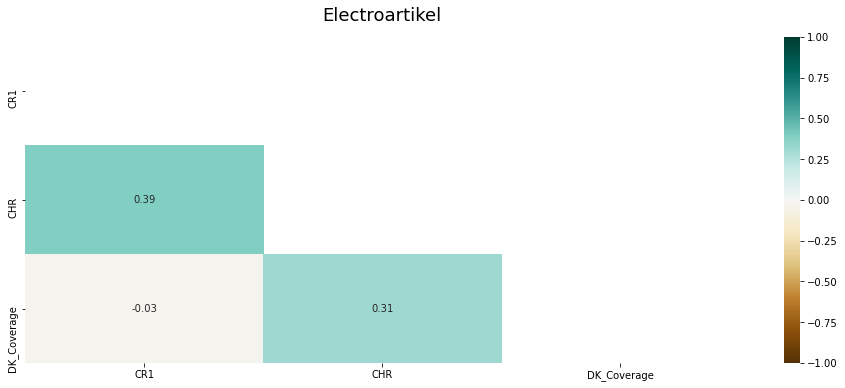

In [31]:
df_2=df_1[(df_1['root_category_name'] == 'Elektroartikel')]
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_2.corr(method='kendall'), dtype=np.bool))
heatmap = sns.heatmap(df_2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Electroartikel', fontdict={'fontsize':18}, pad=16);

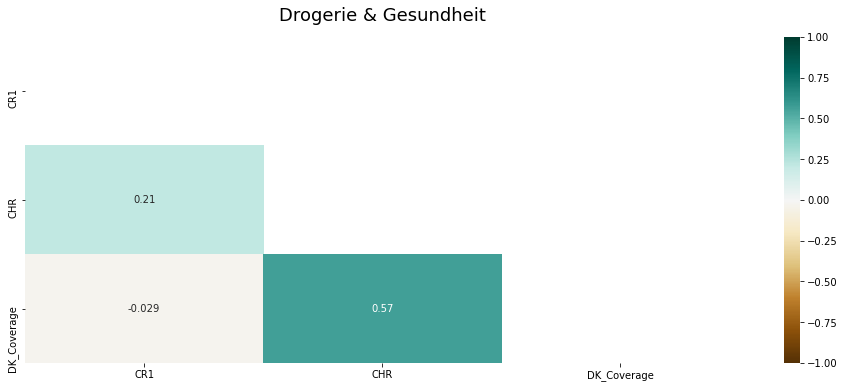

In [28]:
df_2=df_1[(df_1['root_category_name'] == 'Drogerie & Gesundheit')]
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_2.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Drogerie & Gesundheit', fontdict={'fontsize':18}, pad=16);

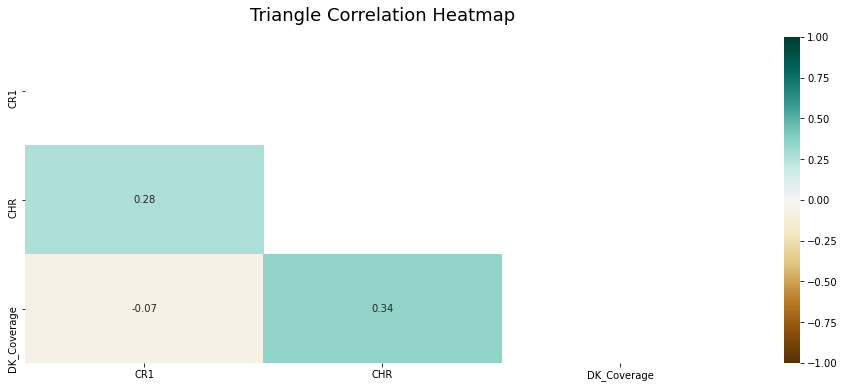

In [17]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_1.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);